[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liambiam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liambiam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    1040
1     120
dtype: int64


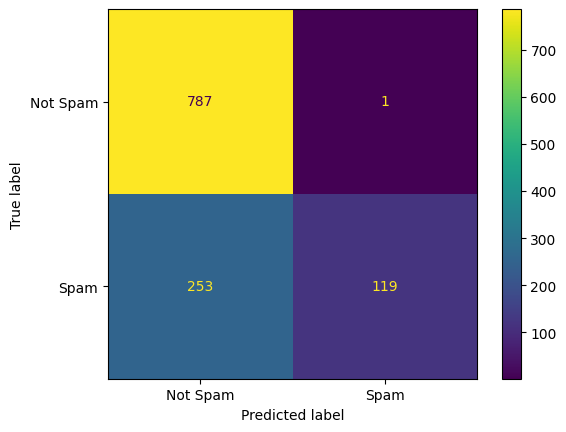

In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('wordnet')
nltk.download('stopwords')

# Read csv into dataframe
df = pd.read_csv('Spam Email raw text for NLP.csv')

# Converts string to tokenized, lowercased, lemmatized, stopworded list
def message_to_token_list(s):
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t not in stopwords]
    return useful_tokens

## TOOLS ##

# Tokenizer with regular expressions matching word character
tokenizer = nltk.RegexpTokenizer(r"\w+")

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Not useful words in English
stopwords = stopwords.words('english')


## PARTITION DATAFRAME FOR TRAIN AND TEST##

# Randomise, reset and remove indices 
df = df.sample(frac=1, random_state=1)
df = df.reset_index(drop=True)

# Split df 80/20
split_index = int(len(df) * 0.8)
train_df, test_df = df[:split_index], df[split_index:]

# Reset indices again
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


## GET HIGH FREQUENCY TOKENS IN TRAIN_DF ##

# Dictionary to be populated with unique tokens
token_counter = {}

# Process each message in train_df
for message in train_df['MESSAGE']:
  message_as_token_list = message_to_token_list(message)

  # Add to dict or create new entry 
  for token in message_as_token_list:
    if token in token_counter:
      token_counter[token] += 1
    else:
      token_counter[token] = 1

# Take a token, return False if not in list or count below threshold, else return True
def keep_token(processed_token, threshold):
    if processed_token not in token_counter:
        return False
    else:
        return token_counter[processed_token] > threshold

# Add token to features set if it is above threshold 10000
features = set()

for token in token_counter:
  if keep_token(token, 10000):
    features.add(token)

# Convert to list with order
features = list(features)

# Map features key to corresponding index
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}


## GET COUNT VECTOR OF MESSAGE ##

def message_to_count_vector(message):

  # Initialise as list of zeroes
  count_vector = np.zeros(len(features))

  # Process message, get tokens
  processed_list_of_tokens = message_to_token_list(message)

  # Iterate through token list
  for token in processed_list_of_tokens:

    # Skip if token not in features list
    if token not in features:
      continue

    # Get corresponding index and update count_vector element by 1
    index = token_to_index_mapping[token]
    count_vector[index] += 1
  
  return count_vector

## INPUT BOTH TRAIN AND TEST DATAFRAMES ##
## OUTPUT COUNT VECTORS ARRAY ##

def df_to_X_y(dff):
  
  # Convert category to integer array (0 not spam, 1 spam)
  y = dff['CATEGORY'].to_numpy().astype(int)

  # Append count_vector for each message to list count_vectors
  message_col = dff['MESSAGE']
  count_vectors = []
  for message in message_col:
    count_vector = message_to_count_vector(message)
    count_vectors.append(count_vector)

  # Convert to numpy array
  X = np.array(count_vectors).astype(int)

  return X, y

# Call functions
X_train, y_train = df_to_X_y(train_df)

X_test, y_test = df_to_X_y(test_df)


## FINAL PROCESSING - VARIOUS BINARY CLASSIFICATIONS##

# Scale data and update X. Only fit using x_train
scaler = MinMaxScaler().fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# Using LR classifier
model = LogisticRegression().fit(X_train, y_train)

# Predicted counts
test_predictions = model.predict(X_test)
print(pd.value_counts(test_predictions))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, test_predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not Spam', 'Spam'])

disp.plot()






#print(classification_report(y_test, model.predict(X_test)))